In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    LearningRateMonitor,
    EarlyStopping,
)
from torchmetrics import Accuracy
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from pipelines.processing.features.spectral_indices import CalculateIndices
from pipelines.processing.features.temporal_features import TemporalFeatures

from models.lstm.lstm_utils.data_loader import CSVDataLoader
from models.lstm.lstm_utils.padded_dataset import PaddedSpeciesDataset
from models.lstm.lstm_utils.utility_functions import df_to_sequences
from models.lstm.lstm_utils.data_module import SpeciesDataModule
from models.lstm.lstm_utils.predictor_species import SpeciesPredictor

TRAIN_PATH = "../../../data/processed/trainset.csv"
VAL_PATH = "../../../data/processed/testset.csv"
TEST_PATH = "../../../data/processed/valset.csv"

loader = CSVDataLoader()
train_df = loader.load_transform(TRAIN_PATH).replace([np.inf, -np.inf], np.nan).fillna(0)
test_df = loader.load_transform(TEST_PATH).replace([np.inf, -np.inf], np.nan).fillna(0)
val_df = loader.load_transform(VAL_PATH).replace([np.inf, -np.inf], np.nan).fillna(0)
print(train_df.shape, test_df.shape, val_df.shape)
train_df

(9714, 37) (1364, 37) (2971, 37)


,time,id,disturbance_year,b2,b3,b4,b5,b6,b7,b8,...,ipvi,mcari,reip,masvi2,dvi,ndmi,nbr,ndwi,mtci,rendvi
0,2017-01-13,4,0.0,176.0,229.0,69.0,329.0,996.0,1113.0,1067.0,...,0.939261,1144.347826,715.712144,-0.999063,998.0,0.563370,0.769486,-0.646605,0.719525,0.543689
1,2017-01-27,4,0.0,382.0,429.0,205.0,405.0,1192.0,1308.0,1316.0,...,0.865220,404.604878,717.865311,-0.999240,1111.0,0.537383,0.759358,-0.508309,0.797366,0.527145
2,2017-02-19,4,0.0,240.0,382.0,259.0,544.0,1387.0,1609.0,1825.0,...,0.875720,530.557529,718.505338,-0.999452,1566.0,0.427454,0.687471,-0.653829,0.747340,0.494659
3,2017-03-27,4,0.0,244.0,375.0,287.0,579.0,1536.0,1776.0,1878.0,...,0.867436,506.776307,718.913271,-0.999468,1591.0,0.299204,0.587489,-0.667111,0.766213,0.508280
4,2017-04-27,4,0.0,215.0,327.0,274.0,548.0,1499.0,1803.0,1766.0,...,0.865686,459.600000,720.630915,-0.999434,1492.0,0.275551,0.531657,-0.687530,0.776327,0.533815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9709,2022-06-27,99,0.0,285.0,474.0,271.0,767.0,2519.0,3116.0,2898.0,...,0.914484,1237.954982,721.152968,-0.999655,2627.0,0.369242,0.671762,-0.718861,0.779359,0.604945
9710,2022-07-23,99,0.0,235.0,403.0,247.0,627.0,1936.0,2454.0,2211.0,...,0.899512,850.892308,722.108480,-0.999548,1964.0,0.310999,0.603336,-0.691660,0.775015,0.592989
9711,2022-07-24,99,0.0,172.0,315.0,157.0,540.0,1818.0,2214.0,2166.0,...,0.932415,1162.547771,720.203443,-0.999538,2009.0,0.326393,0.628571,-0.746070,0.769416,0.607843
9712,2022-08-01,99,0.0,240.0,417.0,244.0,638.0,1956.0,2235.0,2376.0,...,0.906870,914.640984,718.254932,-0.999579,2132.0,0.334831,0.642018,-0.701396,0.769860,0.555865


In [2]:

feature_columns = [
    c
    for c in train_df.columns
    if c not in ["time", "id", "species", "disturbance_year"]
]
label_column = "species"

# Encode labels
le = LabelEncoder()
train_df[label_column] = le.fit_transform(train_df[label_column])
test_df[label_column] = le.transform(test_df[label_column])
val_df[label_column] = le.transform(val_df[label_column])

# Feature scaling
scaler = StandardScaler()
train_df[feature_columns] = scaler.fit_transform(train_df[feature_columns])
test_df[feature_columns] = scaler.transform(test_df[feature_columns])
val_df[feature_columns] = scaler.transform(val_df[feature_columns])


# Sequences
train_sequences = df_to_sequences(train_df, feature_columns, label_column)
test_sequences = df_to_sequences(test_df, feature_columns, label_column)
val_sequences = df_to_sequences(val_df, feature_columns, label_column)

data = {
    "train_sequences": train_sequences,
    "test_sequences": test_sequences,
    "val_sequences": val_sequences,
    "feature_columns": feature_columns,
    "n_classes": len(le.classes_),
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

In [3]:
batch_size = 16
lr = 1e-3
max_epochs = 5

labels = [y for _, y in train_sequences]
counts = Counter(labels)
class_weights = [
    1.0 / counts[i] if i in counts else 0.0 for i in range(data["n_classes"])
]

data_module = SpeciesDataModule(
    train_sequences, test_sequences, val_sequences, batch_size
)
model = SpeciesPredictor(len(feature_columns), data["n_classes"], lr, class_weights)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="trained_model/",
    filename="species_model-{epoch:02d}-{val_loss:.4f}",
    save_top_k=1,
    mode="min",
)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    log_every_n_steps=1,
    deterministic=True,
    callbacks=[
        checkpoint_callback,
        LearningRateMonitor(logging_interval="epoch"),
        EarlyStopping(monitor="val_acc", patience=10),
    ],
)

trainer.fit(model, datamodule=data_module)
trainer.test(model, datamodule=data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-10-17 10:13:48.552861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-17 10:13:48.579017: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-17 10:13:48.579058: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-17 10:13:48.595049: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operation

Epoch 4: 100%|██████████| 5/5 [00:08<00:00,  0.57it/s, v_num=42, train_loss=1.920, train_acc=0.167, val_loss=1.920, val_acc=0.100] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │    1.9570738077163696     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.9570738077163696, 'test_acc': 0.10000000149011612}]

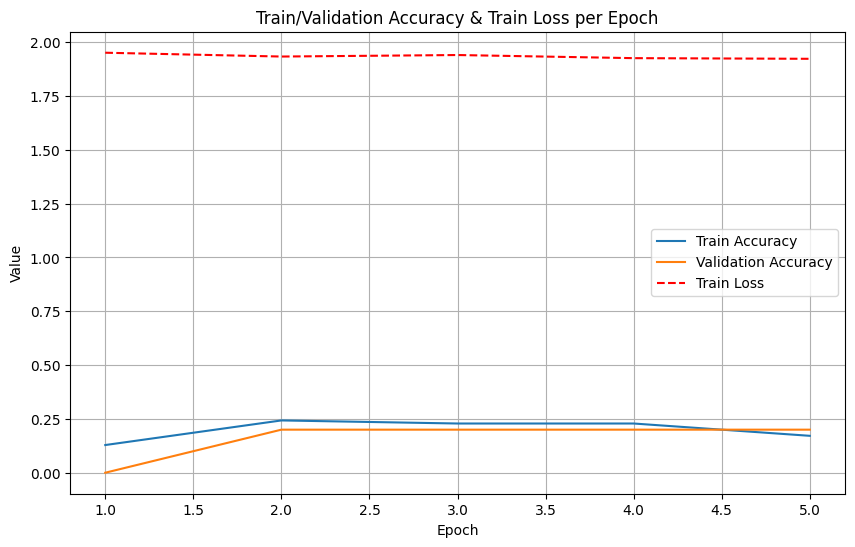

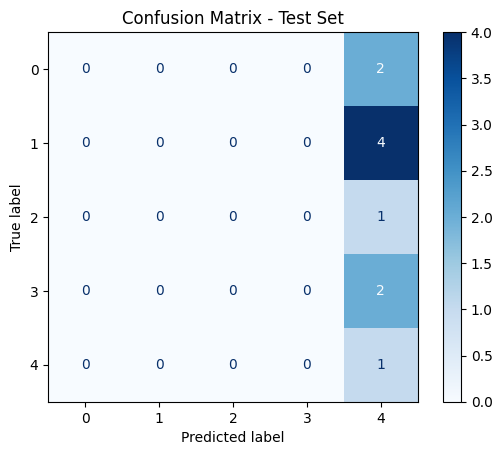

In [4]:
plt.figure(figsize=(10, 6))


min_len = min(
    len(model.train_acc_history),
    len(model.train_loss_history),
    len(model.val_acc_history),
)

epochs = range(1, min_len + 1)

# Listen auf gleiche Länge kürzen
train_acc = model.train_acc_history[:min_len]
train_loss = model.train_loss_history[:min_len]
val_acc = model.val_acc_history[:min_len]

# Plot Accuracy + Loss
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.plot(epochs, train_loss, label="Train Loss", linestyle="--", color="red")

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Train/Validation Accuracy & Train Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
all_labels, all_preds = [], []
device = data["device"]

for batch in data_module.test_dataloader():
    seq_batch = batch["sequence"].to(device)
    labels = batch["label"].to(device)
    with torch.no_grad():
        outputs = model(seq_batch)
        preds = torch.argmax(outputs, dim=1)
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()